# RF Power Broadening in PPM Sample




The following demonstrates the broadening of spectral lines in the electronic states of an NV^-1 center in diamond, caused by increasing RF magnetic field power, which controls the transition betweent the ground and excited spin states. 

In the ppm sample used here, two RF-induced resonances were observed about the expected central zero-field split of 2.87 GHz. The double-peak was found for all values of RF power tested. 

This approach uses CW ODMR to measure the reduction in PL as a function of RF frequency and power. For each frequency scan at a particular power, a double lorentzian was fit to the data and the average line-width of both peaks were estimated. 
By varying the RF power, a clear trend of increased line width with increased power was observed.
Extrapolation to zero RF power suggests a minimum line width of XX MHz, which corresponds to a driven decoherence time of $T_{2}^{*} \approx YY \mu s$  for this sample.



In [1]:
%load_ext autoreload
%autoreload 2

In [77]:
%matplotlib notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy import optimize
import copy
from scipy.optimize import leastsq
import scipy 

import logging


In [6]:
import qt3utils.experiments.ramsey
import qt3utils.experiments.cwodmr
import qt3utils.experiments.podmr
import qt3utils.experiments.rabi

from qt3utils.experiments.pulsers.pulseblaster import PulseBlasterRamHahnDD, PulseBlasterCWODMR, PulseBlasterPulsedODMR, PulseBlasterHoldAOM
import qt3utils.nidaq
import qcsapphire
import qt3rfsynthcontrol

import nipiezojenapy
import qt3utils.datagenerators as datasources
import qt3utils.datagenerators.piezoscanner
import qt3utils.nidaq.config

# Set Logging Levels

This controls output print statements, which can be useful for debugging and knowing that scans are running

In [7]:
logging.basicConfig(level=logging.WARNING)

In [8]:
qt3utils.experiments.cwodmr.logger.setLevel(logging.WARNING)

# Create objects to control hardware

In [9]:
rfsynth = qt3rfsynthcontrol.QT3SynthHD('COM5')

In [10]:
aom_hold = PulseBlasterHoldAOM()

In [11]:
aom_hold.program_pulser_state()
aom_hold.start() #do this to during confocal san

In [12]:
cwodmr_pulser = PulseBlasterCWODMR(clock_period = 200e-9)

In [13]:
nidaq_config = qt3utils.nidaq.EdgeCounter('Dev1')

In [69]:
def plot_contrast_scan(scan, xlabel = 'frequency [Hz]', figsize = (10,6), marker = 'o-'):
    scan = np.array(scan)

    x_data = scan[:, 0]
    y_data = scan[:, 1]

    plt.figure(figsize=figsize)
    plt.plot(x_data, y_data, marker, label='Data')

    plt.xlabel(xlabel)

In [15]:
# some fitting functions

def lorentzian( x, center, amplitude, width ):
    return amplitude * width**2 / ( width**2 + ( x - center )**2)

def multi_lorentz( x, *params ):
    off = params[0]
    paramsRest = params[1:]
    assert not ( len( paramsRest ) % 3 )
    return off + sum( [ lorentzian( x, *paramsRest[ i : i+3 ] ) for i in range( 0, len( paramsRest ), 3 ) ] )

def _2_lorentz_fixed_peak_diff(x, *params):
        offset = params[0]
        return offset + lorentzian(x, params[1], params[2], params[3]) + lorentzian(x, params[1] + params[4], params[5], params[6])

def res_multi_lorentz(xData, yData, *params):
    diff = [ multi_lorentz( x, *params ) - y for x, y in zip( xData, yData ) ]
    return diff



In [16]:
#more fitting stuff

def get_pars(p_opt, p_covariance):
    p_errors = np.sqrt(np.diag(p_covariance))

    offset = p_opt[0]
    offset_err = p_errors[0]

    pars_1 = p_opt[1:4]
    errs_1 = p_errors[1:4]
    pars_2 = p_opt[4:7]
    errs_2 = p_errors[4:7]
    
    mean_width  =  np.mean([pars_1[2], pars_2[2]])
    
    return offset, pars_1, pars_2, errs_1, errs_2, mean_width

def fit_double_lorentz(x, y, amp1 = 3, amp2 = 3, cen1 = 2865, cen2 = 2875, wid1 = 10, wid2 = 10, fixed_delta = None):

    params = [0, cen1, amp1, wid1, cen2, amp2, wid2]
    bounds = (0, np.inf)
    
    fit_function = multi_lorentz
    
    if fixed_delta is not None:
        params[4] = fixed_delta
        bounds = (len(params)*[0], len(params)*[np.inf])
        bounds[0][4] = params[4]-1e-10
        bounds[1][4] = params[4]+1e-10
        fit_function = _2_lorentz_fixed_peak_diff
        
    p_opt, p_cov = scipy.optimize.curve_fit(fit_function, x, y, 
                                            p0=params, 
                                            maxfev = 10000, 
                                            bounds = bounds)
    return p_opt, p_cov

# def fit_double_lorentz_with_fixed_peak_diff(x, y, delta, amp1 = 3, amp2 = 3, cen1 = 2865, wid1 = 10, wid2 = 10):
    
#     def _2_lorentz_fixed_peak_diff(x, *params):
#         offset = params[0]
#         return offset + lorentzian(x, params[1], params[2], params[3]) + lorentzian(x, params[1] + delta, params[4], params[5])

#     params = [0, cen1, amp1, wid1, amp2, wid2]
#     p_opt, p_cov = scipy.optimize.curve_fit(_2_lorentz_fixed_peak_diff, x, y, p0=[0, cen1, amp1, wid1, amp2, wid2], maxfev = 10000)
#     return p_opt, p_cov


In [17]:
def plot_fit(x, y, p_opt):
    plt.figure(figsize=(10, 6))

    plt.plot(x, y, 'o-', label='Data')
    plt.plot(x, multi_lorentz(x, *p_opt), 'k--', label='Fit')
    plt.legend()

# Confocal Scan
Either run a scan here in the notebook, or use qt3scan and save. qt3scan was used and we load the scan here.

Laser power was ~25 microWatts (according the to photodiode). This has a large uncertainty, it appears, as repeated readings range +- 5 microWatts


Todo -- calibrate with external power meter

In [22]:
scan_file = 'large_scan_x0t80_y0t57.npy'
confocal_scan = np.load(scan_file)

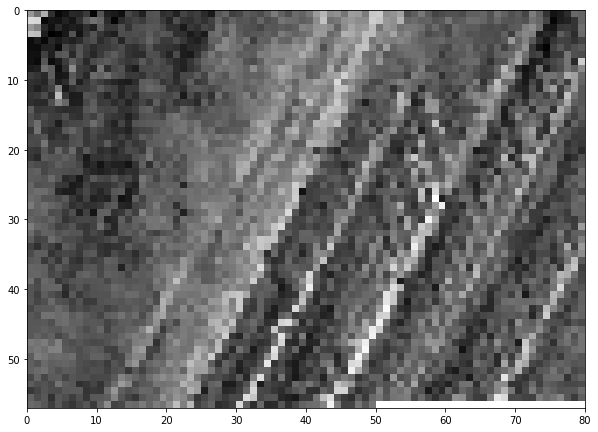

In [23]:
plt.figure(figsize=(10,10))
plt.imshow(confocal_scan, cmap='Greys_r', extent = [0,80,57,0])

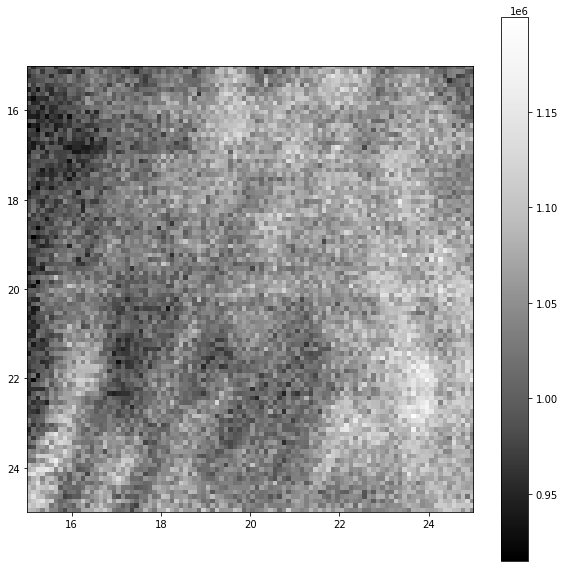

In [25]:
scan_file = 'highres_scan_x15t25_y15t25.npy'
confocal_scan = np.load(scan_file)

fig, ax = plt.subplots(figsize=(10,10))
artist = ax.imshow(confocal_scan, cmap='Greys_r', extent = [15,25,25,15])
cbar = fig.colorbar(artist, ax=ax)
cbar.formatter.set_powerlimits((0, 3))

In [26]:
cwodmr_exp = qt3utils.experiments.cwodmr.CWODMR(cwodmr_pulser, rfsynth, nidaq_config,
                                                  rf_power=-10)

In [46]:
qt3utils.experiments.cwodmr.logger.setLevel(logging.INFO)


In [28]:
cwodmr_exp.experimental_conditions()

{'freq_low': 2820000000.0,
 'freq_high': 2920000000.0,
 'freq_step': 1000000.0,
 'rf_power': -10,
 'pulser': {'rf_width': 5e-06, 'clock_period': 2e-07}}

In [52]:
def scan_with_powers(experiment, rf_powers, line_widths = {}, fixed_delta = None, N_cycles = 10000, random_order = False):

    for a_pow in rf_powers:
        print(a_pow)
        experiment.rf_power = a_pow

        scan_data = experiment.run(N_cycles=N_cycles, random_order = random_order)

        scan_data = np.array(scan_data)
        xData = scan_data[:, 0]*1e-6 #in MHz
        yData = scan_data[:, 1]

        yData = 1 - yData
        yData = yData*100
    
        optimized_p, cov_p = fit_double_lorentz(xData, yData, fixed_delta = fixed_delta)

        offset, pars_1, pars_2, errs_1, errs_2, mean_width = get_pars(optimized_p, cov_p)
        line_width_sigma = np.sqrt(errs_1[2]**2 + errs_2[2]**2)

        line_widths[a_pow] = {'p_opt': optimized_p,
                              'p_cov':cov_p,
                              'mean_width':mean_width,
                              'mean_width_sigma':line_width_sigma,
                              'x':xData,
                              'y':yData,
                              'scan':scan_data,
                              'fixed_delta':fixed_delta,
                              'experiment_conditions':experiment.experimental_conditions()}
        
    return line_widths



def plot_spectrum_and_accumulate_line_widths(line_widths):
    rf_power_line_width = []

    for a_pow, res in line_widths.items():
        fixed_delta = res.get('fixed_delta', None)
        opt_p = copy.deepcopy(res['p_opt'])
        if fixed_delta is not None:
            opt_p[4] = opt_p[1] + fixed_delta
        plot_fit(res['x'], res['y'], opt_p)
        plt.title(f'RF Power = {a_pow}, Line Width = {res["mean_width"]:0.2f} MHz')
        plt.xlabel('frequency [MHz]')
        plt.ylabel('PL loss [percent]')
        rf_power_line_width.append([a_pow, res['mean_width'], res['mean_width_sigma']])

    return rf_power_line_width

In [61]:
cwodmr_exp.freq_low = 2700e6
cwodmr_exp.freq_high = 3200e6
cwodmr_exp.freq_step = 1e6

In [62]:
line_widths = scan_with_powers(cwodmr_exp, [-10], N_cycles = 200000)

INFO:qt3utils.experiments.cwodmr:RF frequency: 2700000000.0 Hz


-10


INFO:qt3utils.experiments.cwodmr:RF frequency: 2701000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2702000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2703000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2704000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2705000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2706000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2707000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2708000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2709000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2710000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2711000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2712000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2713000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2714000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2715000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 27160000

INFO:qt3utils.experiments.cwodmr:RF frequency: 2832000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2833000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2834000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2835000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2836000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2837000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2838000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2839000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2840000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2841000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2842000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2843000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2844000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2845000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2846000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 28470000

INFO:qt3utils.experiments.cwodmr:RF frequency: 2963000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2964000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2965000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2966000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2967000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2968000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2969000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2970000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2971000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2972000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2973000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2974000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2975000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2976000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2977000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 29780000

INFO:qt3utils.experiments.cwodmr:RF frequency: 3094000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 3095000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 3096000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 3097000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 3098000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 3099000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 3100000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 3101000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 3102000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 3103000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 3104000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 3105000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 3106000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 3107000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 3108000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 31090000

<IPython.core.display.Javascript object>


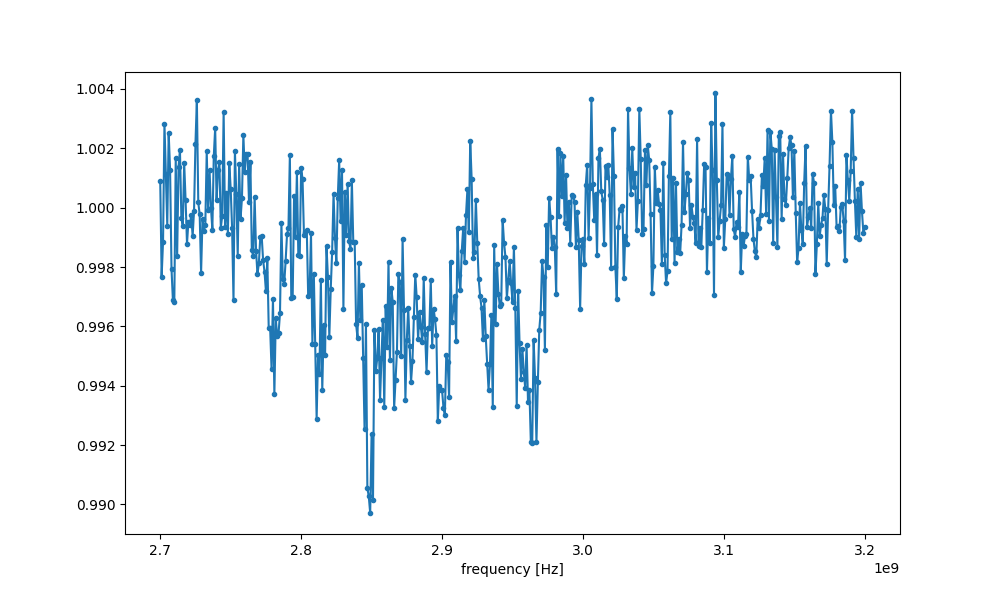

In [80]:
plot_contrast_scan(line_widths[-10]['scan'], marker = '.-')

In [63]:
line_widths = scan_with_powers(cwodmr_exp, [-15], line_widths = line_widths, N_cycles = 200000)

INFO:qt3utils.experiments.cwodmr:RF frequency: 2700000000.0 Hz


-15


INFO:qt3utils.experiments.cwodmr:RF frequency: 2701000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2702000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2703000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2704000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2705000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2706000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2707000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2708000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2709000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2710000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2711000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2712000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2713000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2714000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2715000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 27160000

INFO:qt3utils.experiments.cwodmr:RF frequency: 2832000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2833000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2834000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2835000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2836000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2837000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2838000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2839000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2840000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2841000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2842000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2843000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2844000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2845000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2846000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 28470000

INFO:qt3utils.experiments.cwodmr:RF frequency: 2963000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2964000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2965000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2966000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2967000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2968000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2969000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2970000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2971000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2972000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2973000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2974000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2975000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2976000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2977000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 29780000

INFO:qt3utils.experiments.cwodmr:RF frequency: 3094000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 3095000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 3096000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 3097000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 3098000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 3099000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 3100000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 3101000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 3102000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 3103000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 3104000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 3105000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 3106000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 3107000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 3108000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 31090000

<IPython.core.display.Javascript object>


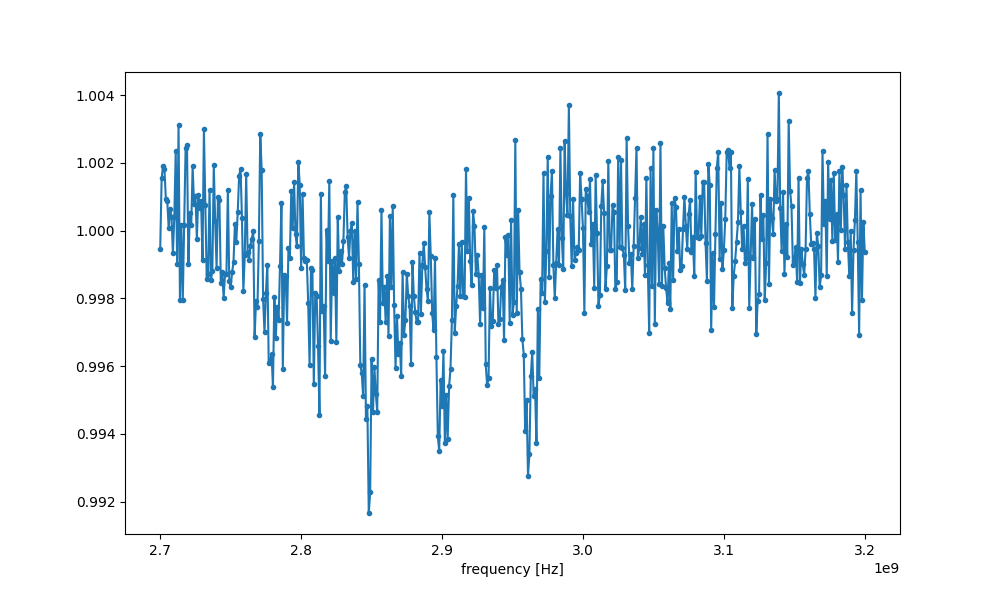

In [81]:
plot_contrast_scan(line_widths[-15]['scan'],  marker = '.-')

In [84]:
line_widths.keys()

dict_keys([-10, -15])

In [83]:
cwodmr_exp.freq_high = 3000e6

In [85]:
line_widths = scan_with_powers(cwodmr_exp, [-5], line_widths = line_widths, N_cycles = 160000)

INFO:qt3utils.experiments.cwodmr:RF frequency: 2700000000.0 Hz


-5


INFO:qt3utils.experiments.cwodmr:RF frequency: 2701000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2702000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2703000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2704000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2705000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2706000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2707000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2708000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2709000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2710000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2711000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2712000000.0 Hz
ERROR:qt3utils.experiments.cwodmr:


In [86]:
cwodmr_exp.experimental_conditions()

{'freq_low': 2700000000.0,
 'freq_high': 3100000000.0,
 'freq_step': 1000000.0,
 'rf_power': -5,
 'pulser': {'rf_width': 5e-06, 'clock_period': 2e-07}}

In [100]:
cwodmr_exp.pulser.rf_width = 1e-3
cwodmr_exp.freq_low = 2830e6
cwodmr_exp.freq_high = 2880e6
cwodmr_exp.pulser.clock_period = 100e-6

In [101]:
cwodmr_exp.pulser.reset()

In [104]:
line_widths = scan_with_powers(cwodmr_exp, [-15], line_widths = line_widths, N_cycles = 200)

INFO:qt3utils.experiments.cwodmr:RF frequency: 2830000000.0 Hz


-15


INFO:qt3utils.experiments.cwodmr:RF frequency: 2831000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2832000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2833000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2834000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2835000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2836000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2837000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2838000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2839000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2840000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2841000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2842000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2843000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2844000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2845000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 28460000

<IPython.core.display.Javascript object>


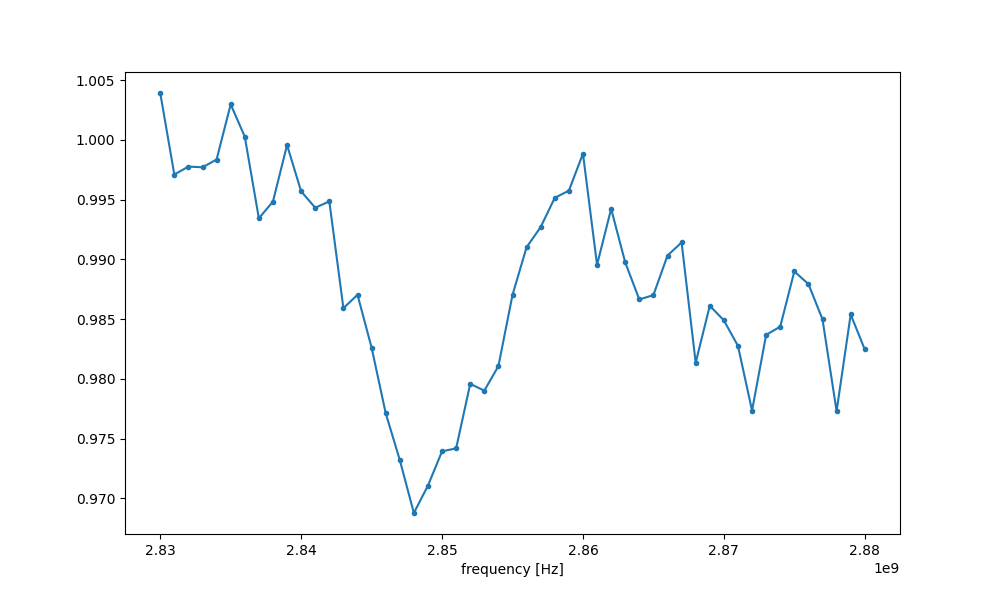

In [105]:
plot_contrast_scan(line_widths[-15]['scan'],  marker = '.-')

In [106]:
line_widths = scan_with_powers(cwodmr_exp, [-20], line_widths = line_widths, N_cycles = 200)

INFO:qt3utils.experiments.cwodmr:RF frequency: 2830000000.0 Hz


-20


INFO:qt3utils.experiments.cwodmr:RF frequency: 2831000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2832000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2833000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2834000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2835000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2836000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2837000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2838000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2839000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2840000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2841000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2842000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2843000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2844000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2845000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 28460000

<IPython.core.display.Javascript object>


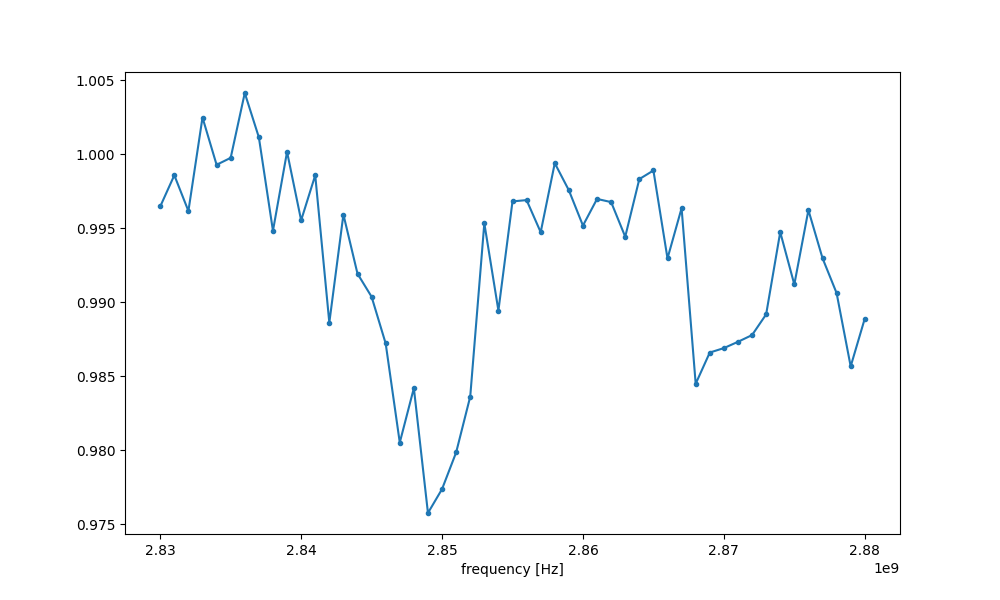

In [107]:
plot_contrast_scan(line_widths[-20]['scan'],  marker = '.-')

INFO:qt3utils.experiments.cwodmr:RF frequency: 2830000000.0 Hz


-25


INFO:qt3utils.experiments.cwodmr:RF frequency: 2831000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2832000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2833000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2834000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2835000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2836000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2837000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2838000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2839000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2840000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2841000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2842000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2843000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2844000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2845000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 28460000

<IPython.core.display.Javascript object>


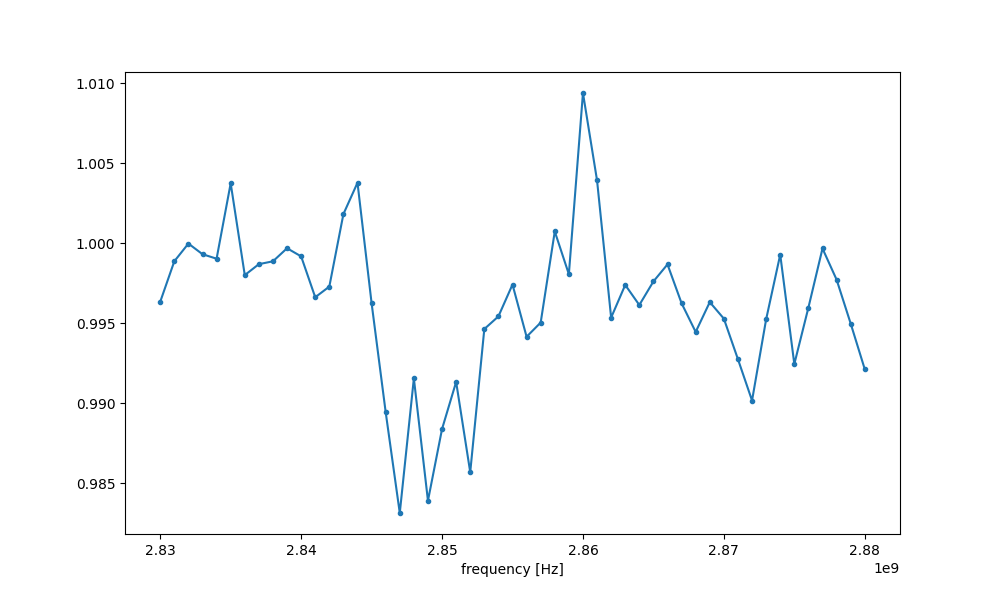

In [108]:
line_widths = scan_with_powers(cwodmr_exp, [-25], line_widths = line_widths, N_cycles = 200)
plot_contrast_scan(line_widths[-25]['scan'],  marker = '.-')

INFO:qt3utils.experiments.cwodmr:RF frequency: 2840000000.0 Hz


-25


INFO:qt3utils.experiments.cwodmr:RF frequency: 2840250000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2840500000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2840750000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2841000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2841250000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2841500000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2841750000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2842000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2842250000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2842500000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2842750000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2843000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2843250000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2843500000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2843750000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 28440000

<IPython.core.display.Javascript object>


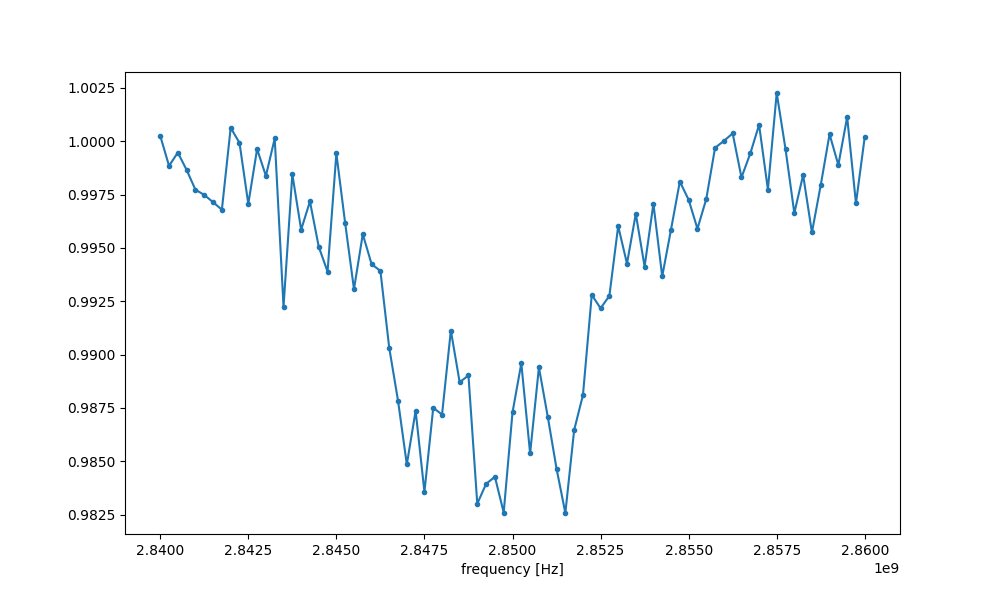

In [109]:
cwodmr_exp.freq_step = 0.25e6
cwodmr_exp.freq_low = 2840e6
cwodmr_exp.freq_high = 2860e6

line_widths = scan_with_powers(cwodmr_exp, [-25], line_widths = line_widths, N_cycles = 600)
plot_contrast_scan(line_widths[-25]['scan'],  marker = '.-')

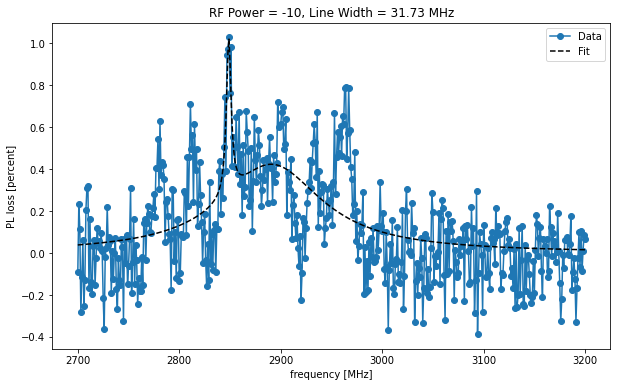

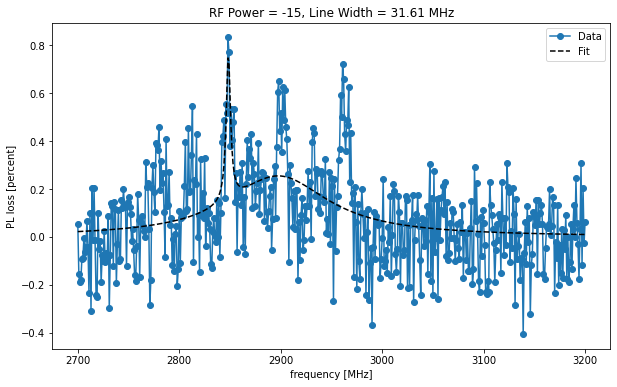

In [66]:
rf_power_line_width = plot_spectrum_and_accumulate_line_widths(line_widths)

In [142]:
#with reduced counts, we need to fix the width of the double peaks based on brighter data
#for lower power RF scan below, the delta between the peaks will be fixed
central_peak_deltas = []

for a_pow, res in line_widths.items():
    if a_pow >= -25:
        offset, pars_1, pars_2, errs_1, errs_2, mean_width = get_pars(res['p_opt'], res['p_cov'])
        delta = pars_2[0] - pars_1[0]
        central_peak_deltas.append(delta)
   

In [143]:
np.mean(central_peak_deltas)

7.70649840339441

In [177]:
import pickle

In [178]:
save_data_name = 'rf_power_broadening_ppmsample_w_B_ext_cwodmr.oct25.2022.pickle'

In [179]:
def save_file(name, data):
    with open(name, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_file(name):
    with open(name, 'rb') as handle:
        return pickle.load(handle)

In [180]:
save_file(save_data_name, line_widths)

In [185]:
for a_pow in [-35, -38, -40, -45]:
    print(a_pow)
    cwodmr_exp.rf_power = a_pow
    cwscan = cwodmr_exp.run(N_cycles=1000000, post_process_function=measure_cwodrm_contrast)
    
    cwscan = np.array(cwscan)
    xData = cwscan[:, 0]*1e-6 #in MHz
    yData = cwscan[:, 1]

    yData = 1 - yData
    yData = yData*100

    optimized_p, cov_p = fit_double_lorentz(xData, yData, fixed_delta = np.mean(central_peak_deltas))
    mean_width = get_pars(optimized_p, cov_p)[-1] #last parameter returns by this functionis the mean width in MHz

    line_widths[a_pow] = {'p_opt': optimized_p,
                          'p_cov':cov_p,
                          'mean_width':mean_width,
                          'x':xData,
                          'y':yData,
                          'scan':cwscan,
                          'fixed_delta':np.mean(central_peak_deltas)}

-35
-38
-40
-45


In [193]:
for a_pow in [-35, -38, -40, -45]:
    print(line_widths[a_pow]['p_opt'])

[8.94717858e-49 2.86686925e+03 3.71187771e-01 2.67039877e+00
 7.70649840e+00 4.28205261e-01 2.87585586e+00]
[8.61609825e-282 2.86762992e+003 3.71394223e-001 4.17690519e+000
 7.70649840e+000 4.54740066e+002 7.85063900e-003]
[1.01826713e-46 2.86842242e+03 2.49957453e-01 2.43335105e+00
 7.70649840e+00 1.15942579e-01 1.91471499e+00]
[1.89621260e-03 2.86658009e+03 1.11710612e-04 2.00918301e-02
 7.70649840e+00 1.22528402e-01 2.30187904e+00]


In [190]:
save_file(save_data_name, line_widths)

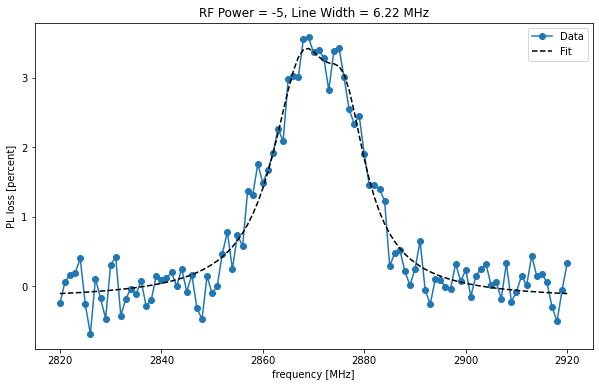

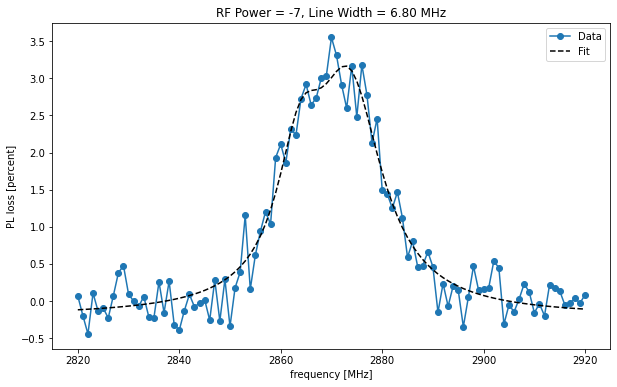

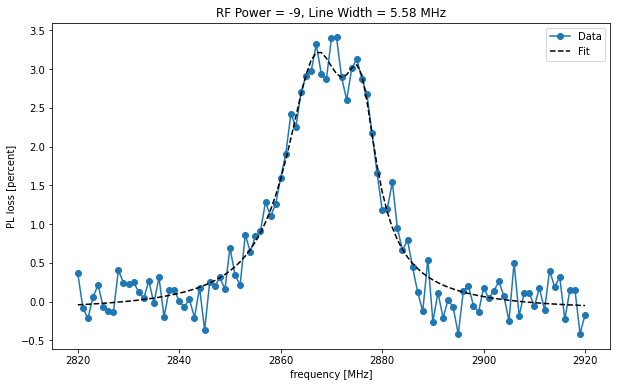

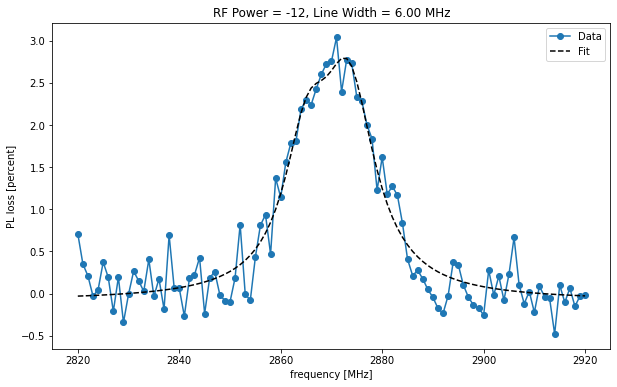

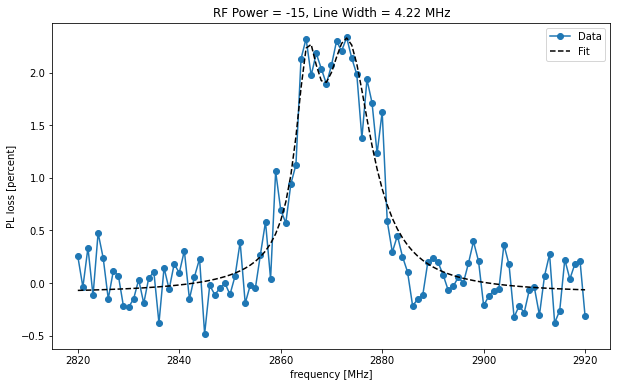

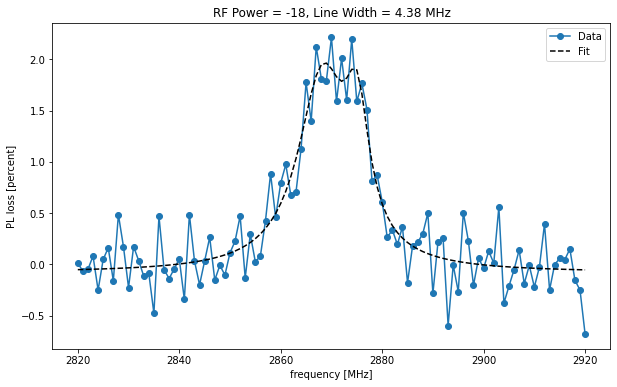

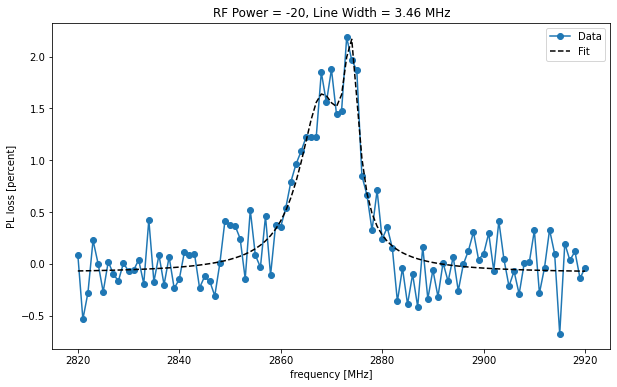

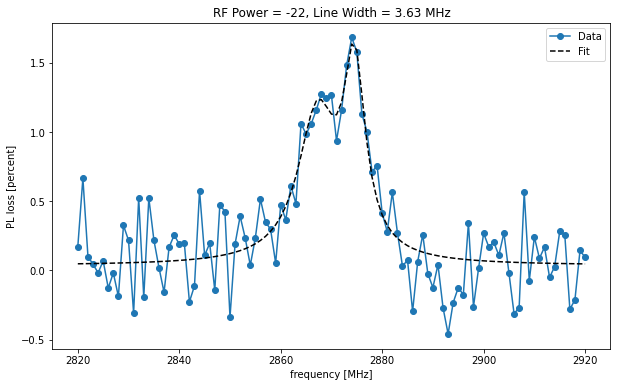

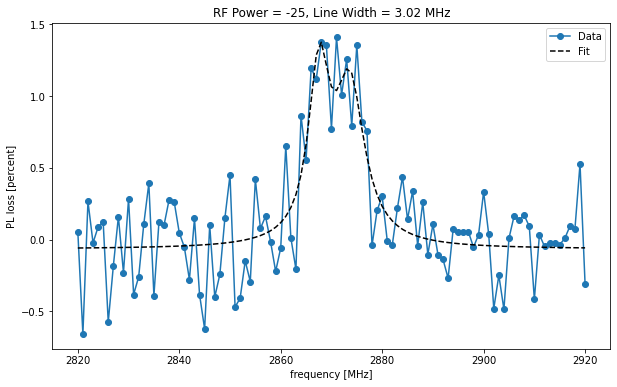

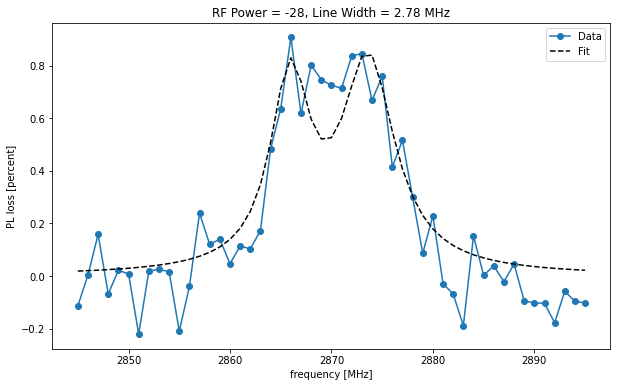

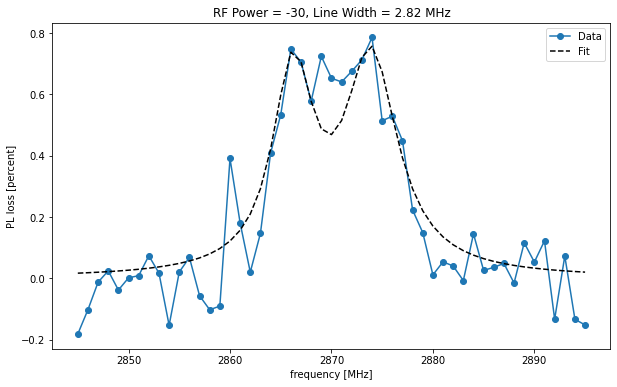

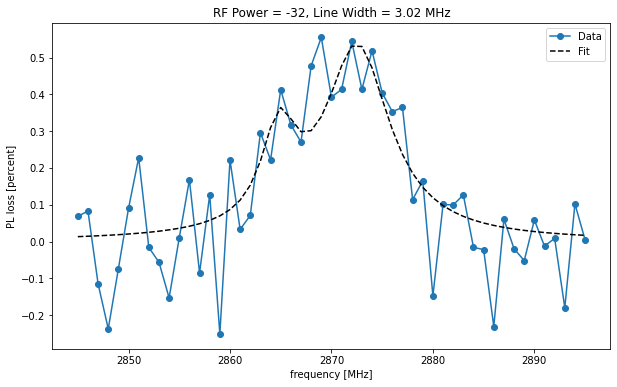

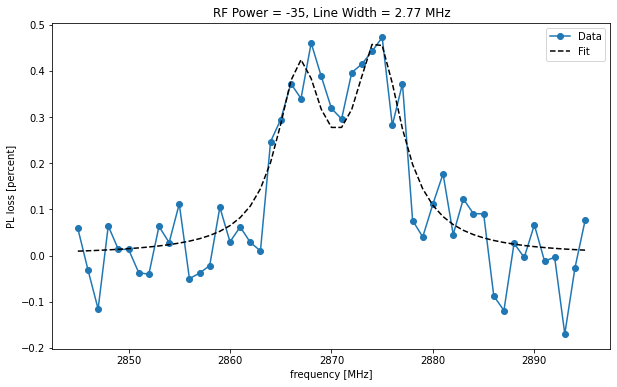

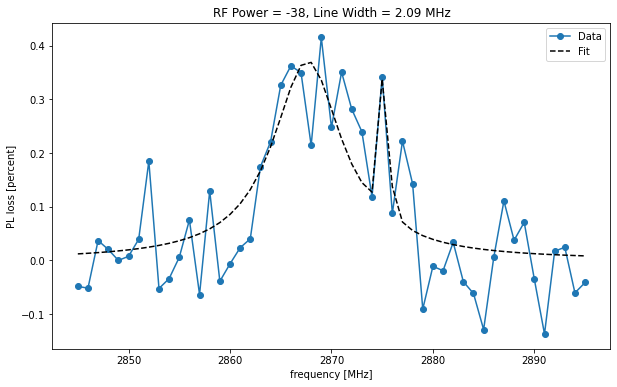

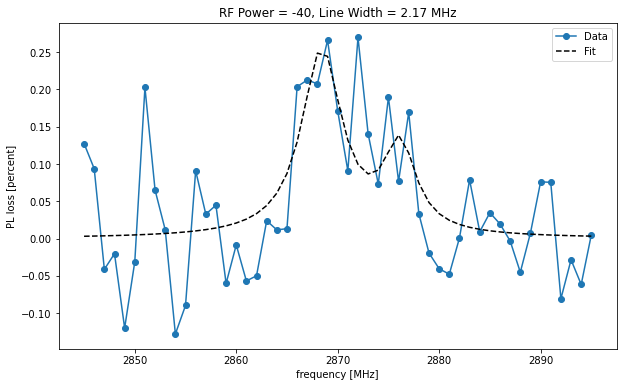

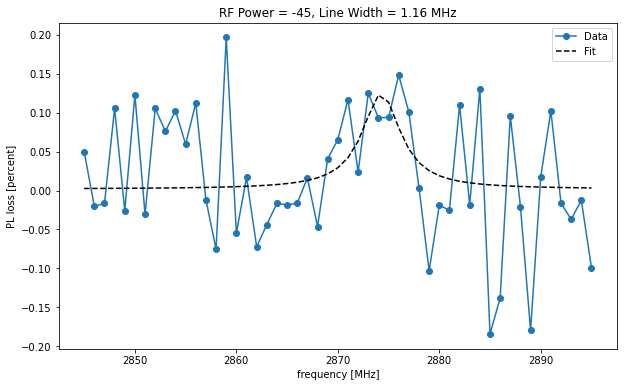

In [191]:

rf_power_line_width = []

for a_pow, res in line_widths.items():
    fixed_delta = res.get('fixed_delta', 0)
    opt_p = copy.deepcopy(res['p_opt'])
    if fixed_delta != 0:
        opt_p[4] = opt_p[1] + fixed_delta
    plot_fit(res['x'], res['y'], opt_p)
    plt.title(f'RF Power = {a_pow}, Line Width = {res["mean_width"]:0.2f} MHz')
    plt.xlabel('frequency [MHz]')
    plt.ylabel('PL loss [percent]')
    rf_power_line_width.append([a_pow, res['mean_width']])
    


Text(0, 0.5, 'linewidth [MHz]')

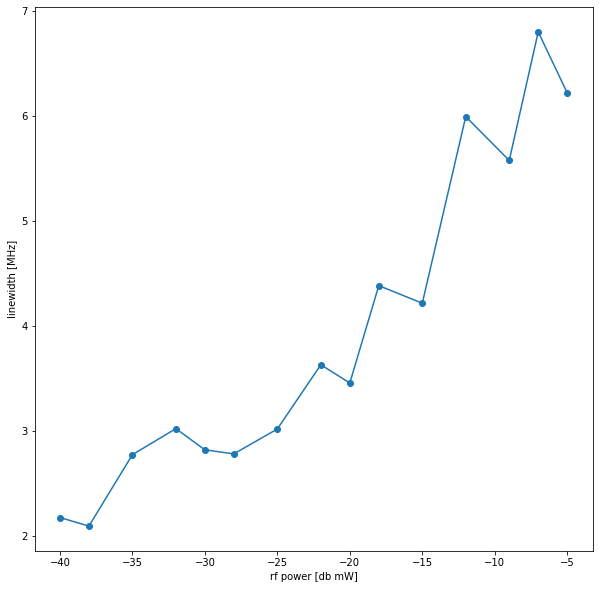

In [196]:
plt.figure(figsize=(10,10))
rf_power_line_width = np.array(rf_power_line_width)

#drop the last measurement as the data quality is very poor
#should add error bars to the estimated line widths
plt.plot(rf_power_line_width[:-1, 0], rf_power_line_width[:-1, 1], 'o-', label='Data')
plt.xlabel('rf power [db mW]')
plt.ylabel('linewidth [MHz]')